<a href="https://colab.research.google.com/github/Alam040/heatwave/blob/main/HeatWave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from google.colab import drive
#drive.mount('/content/drive')


In [2]:
#Load dataset from Google Drive
dataset_path = '/content/drive/My Drive/dataset/open-meteo-23.80N90.29E5m.csv'


# Load the dataset
data = pd.read_csv('open-meteo-23.80N90.29E5m.csv')
#data = pd.read_csv(dataset_path)

# Preprocessing
## Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'])

## Set 'time' as index
data.set_index('time', inplace=True)

data.head()

,temperature,humidity,dew_point,apparent_temperature,wind_speed
time,,,,,
2000-01-01 00:00:00,15.6,80,12.3,15.1,21.9
2000-01-01 01:00:00,15.2,80,11.8,14.4,22.9
2000-01-01 02:00:00,14.8,81,11.6,14.0,22.9
2000-01-01 03:00:00,14.4,82,11.5,13.5,22.4
2000-01-01 04:00:00,14.1,84,11.4,13.4,20.3


In [3]:
## Define heatwave state based on temperature thresholds
def classify_state(temp):
    if temp < 36:
        return 'Normal'
    elif 36 <= temp < 38:
        return 'Mild Heatwave'
    elif 38 <= temp < 40:
        return 'Moderate Heatwave'
    elif 40 <= temp < 42:
        return 'Severe Heatwave'
    else:
        return 'Extreme Heatwave'

data['state'] = data['temperature'].apply(classify_state)

In [4]:
data.head()

,temperature,humidity,dew_point,apparent_temperature,wind_speed,state
time,,,,,,
2000-01-01 00:00:00,15.6,80,12.3,15.1,21.9,Normal
2000-01-01 01:00:00,15.2,80,11.8,14.4,22.9,Normal
2000-01-01 02:00:00,14.8,81,11.6,14.0,22.9,Normal
2000-01-01 03:00:00,14.4,82,11.5,13.5,22.4,Normal
2000-01-01 04:00:00,14.1,84,11.4,13.4,20.3,Normal


In [5]:
# Create sequences of states for Markov Chain
states = data['state'].values
transitions = {state: {state_: 0 for state_ in np.unique(states)} for state in np.unique(states)}

for i in range(len(states) - 1):
    curr_state = states[i]
    next_state = states[i + 1]
    transitions[curr_state][next_state] += 1


# Normalize transitions to get probabilities
for state in transitions:
    total = sum(transitions[state].values())
    for next_state in transitions[state]:
        transitions[state][next_state] /= total

print("Transition Probabilities:", transitions)

# Predict next state using Markov Chain
def predict_next_state(current_state):
    probabilities = transitions[current_state]
    next_state = max(probabilities, key=probabilities.get)
    return next_state

# Example: Predict next state given current state
current_state = 'Mild Heatwave'
predicted_state = predict_next_state(current_state)
print(f"Given the current state '{current_state}', the predicted next state is '{predicted_state}'.")


Transition Probabilities: {'Mild Heatwave': {'Mild Heatwave': 0.6252072968490879, 'Moderate Heatwave': 0.06301824212271974, 'Normal': 0.3117744610281924, 'Severe Heatwave': 0.0}, 'Moderate Heatwave': {'Mild Heatwave': 0.2857142857142857, 'Moderate Heatwave': 0.625, 'Normal': 0.05357142857142857, 'Severe Heatwave': 0.03571428571428571}, 'Normal': {'Mild Heatwave': 0.0008911544837075721, 'Moderate Heatwave': 4.617380744598819e-06, 'Normal': 0.9991042281355478, 'Severe Heatwave': 0.0}, 'Severe Heatwave': {'Mild Heatwave': 0.14285714285714285, 'Moderate Heatwave': 0.42857142857142855, 'Normal': 0.0, 'Severe Heatwave': 0.42857142857142855}}
Given the current state 'Mild Heatwave', the predicted next state is 'Mild Heatwave'.


In [6]:
# Deep Learning Model for Heatwave Prediction
## Prepare Data for Sequential Modeling
sequence_length = 10  # Number of previous timesteps to use
sequences = []
labels = []

for i in range(len(states) - sequence_length):
    sequences.append(states[i:i + sequence_length])
    labels.append(states[i + sequence_length])



In [7]:
# Encode states as integers
state_mapping = {'Normal': 0, 'Mild Heatwave': 1, 'Moderate Heatwave': 2, 'Severe Heatwave': 3, 'Extreme Heatwave': 4}
encoded_sequences = [[state_mapping[state] for state in seq] for seq in sequences]
encoded_labels = [state_mapping[label] for label in labels]


In [8]:
# Convert to numpy arrays
X = np.array(encoded_sequences)
y = np.array(encoded_labels)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Build LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='relu')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=10, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9968 - loss: 0.0380 - val_accuracy: 0.9966 - val_loss: 0.0592
Epoch 2/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.9968 - loss: 0.0277 - val_accuracy: 0.9976 - val_loss: 0.0103
Epoch 3/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.9973 - loss: 0.0139 - val_accuracy: 0.9978 - val_loss: 0.0111
Epoch 4/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9975 - loss: 0.0111 - val_accuracy: 0.9977 - val_loss: 0.0183
Epoch 5/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - accuracy: 0.9976 - loss: 0.0152 - val_accuracy: 0.9978 - val_loss: 0.0106
Epoch 6/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - accuracy: 0.9978 - loss: 0.0138 - val_accuracy: 0.9978 - val_loss: 0.0106
Epoch 7/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.9977 - loss: 0.0114 - val_accuracy: 0.9977 - val_loss: 0.0105
Epoch 8/10
5433/5433 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.9977 -

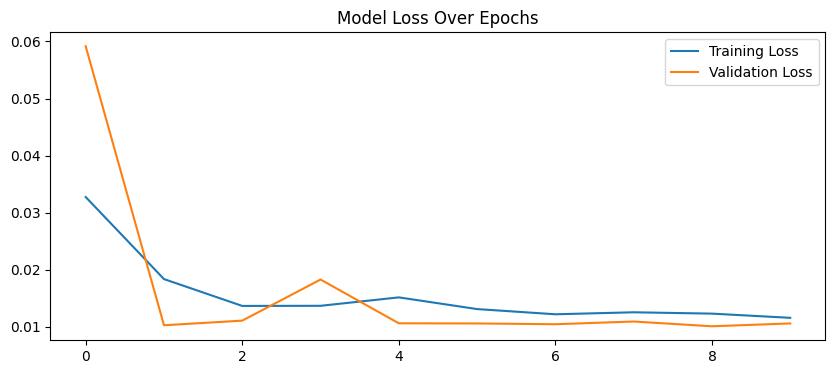

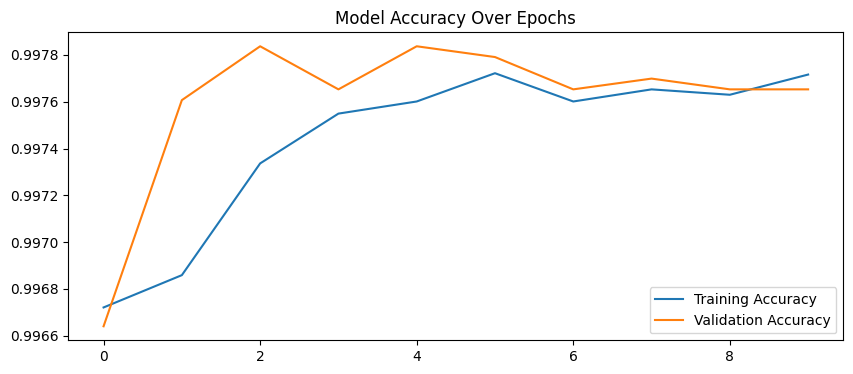

In [10]:
# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

print()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

In [11]:
# Save the Model
model.save('heatwave_prediction_model.h5')
from keras.saving import save_model
save_model(model, 'my_model.keras')

In [12]:
# Predict the next state
def classify_heatwave(prob):
    if prob < 0.4:
        return "Normal"
    elif 0.4 <= prob < 0.6:
        return "Mild Heatwave"
    elif 0.6 <= prob < 0.8:
        return "Moderate Heatwave"
    elif 0.8 <= prob < 0.9:
        return "Severe Heatwave"
    else:
        return "Extreme Heatwave"

In [13]:
def user_defined_prediction(user_sequence):
    encoded_sequence = [state_mapping[state] for state in user_sequence]
    encoded_sequence = np.array(encoded_sequence).reshape((1, sequence_length, 1))
    predicted_prob = model.predict(encoded_sequence)[0][0]
    heatwave_category = classify_heatwave(predicted_prob)
    return predicted_prob, heatwave_category

In [14]:
example_sequence = np.array([state_mapping['Normal']] * (sequence_length - 1) + [state_mapping['Mild Heatwave']])
example_sequence = np.array([0,0,0,0,0,0,0,0,0,1])
print(example_sequence)
example_sequence = example_sequence.reshape((1, sequence_length, 1))
predicted_prob = model.predict(example_sequence)[0][0]
heatwave_category = classify_heatwave(predicted_prob)

print(f"Predicted Probability: {predicted_prob:.2f}")
print(f"Heatwave Category: {heatwave_category}")


[0 0 0 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Predicted Probability: 1.53
Heatwave Category: Extreme Heatwave


In [16]:
from google.colab import drive
# drive.mount('/content/drive')

In [17]:
# Example: User-defined sequence

# Moderate Heatwave
#user_sequence = [35, 37.4, 38, 39, 35.9, 36.6, 40, 40, 42, 37]

# Mild Heatwave
#user_sequence = [33, 37.7, 38, 39, 35, 40, 35, 41, 36, 37.8]

# Extreme Heatwave
#user_sequence = [30.2, 36.5, 40, 42, 38, 39, 33, 34, 38, 36.3]

# Extreme Heatwave
#user_sequence = [30.2, 32.5, 33.9, 33.3, 36.9, 38.1, 39]

# Severe Heatwave
user_sequence = [30.2, 32.5, 33.9, 33.3, 34.9, 34.1, 33, 34.9, 32.6, 36.7]

print(user_sequence)

for i in range(len(user_sequence)):
    user_sequence[i] = classify_state(user_sequence[i])


print(user_sequence)

sequence_length = user_sequence.__len__()
print(sequence_length)
predicted_prob, heatwave_category = user_defined_prediction(user_sequence)

print(f"User Sequence: {user_sequence}")
print(f"Predicted Probability: {predicted_prob:.2f}")
print(f"Heatwave Category: {heatwave_category}")

[30.2, 32.5, 33.9, 33.3, 34.9, 34.1, 33, 34.9, 32.6, 36.7]
['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Mild Heatwave']
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
User Sequence: ['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Mild Heatwave']
Predicted Probability: 1.53
Heatwave Category: Extreme Heatwave
